# Exit Velocity Over Expected

This notebook is an example of a portion of the work that was completed for the EVOE analysis conducted by Sean Sullivan at DePaul University. 

For more information, please visit his website or GitHub repository. 

Website: https://seanwsullivan1.wixsite.com/ssullivananalytics

GitHub: https://github.com/seanwsullivan1

In [1]:
# Load Packages Needed

# Commenting out to not get error. Ran data extraction via Google Colab (previously provided notebook)
#import pybaseball
#from pybaseball import statcast

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#Set CWD
os.chdir('E://DePaul Classes//2020 - 2021//2. Winter//Capstone//Data')

<br>
<br>
<br>

## Load and Clean Data

Data was scraped from Baseball Savant using the pybaseball package. Code to do so is provided below, but will not be ran due to compatability issues with computer being used to make this notebook. 

In [2]:
# Query data from 2017 - 2020 seasons

#pybaseball.cache.enable()

#df = statcast(start_dt='2017-04-02', end_dt='2020-10-27')

In [3]:
# Data is loaded from local machine but is the result of the query above

df = pd.read_csv('all_data_2017_to_2020.csv')
df.shape

C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2486915, 91)

In [4]:
# Drop launch speed IS NULL
df_clean = df.loc[df['launch_speed'].notnull()]
df_clean.shape

(462166, 91)

In [5]:
# Grab the columns you want
df2 = df_clean[['batter', 'pitcher', 'game_date', 'events', 'description', 'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'pfx_x', 
                'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'launch_angle', 
                'launch_speed', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y']]
df2.shape

(462166, 30)

In [6]:
# Get dummies
df2 = pd.get_dummies(df2, columns=['pitch_type'])
df2.shape

(462166, 43)

In [7]:
# Drop rows with NAN
df3 = df2.dropna()
df3.shape

(415952, 43)

In [8]:
# Identified an outlier, need to remove. 
outlier = df3['release_pos_x'].max()
id = df3.index[df3['release_pos_x'] == outlier]

df3 = df3.drop(id)
df3.shape

(415951, 43)

<br>
<br>
<br>

## Basic Data Exploration

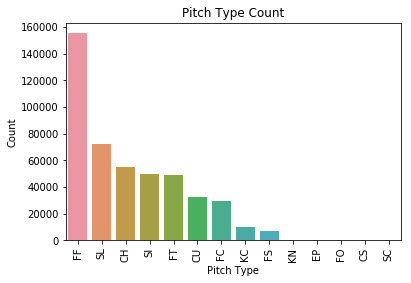

In [9]:
# Evaluate pitch type distribution

ax = sns.countplot(x='pitch_type', data=df_clean, order = df_clean['pitch_type'].value_counts().index)
ax.set_title('Pitch Type Count')
ax.set_xlabel('Pitch Type')
ax.set_ylabel('Count')
plt.xticks(rotation=90)
plt.show()

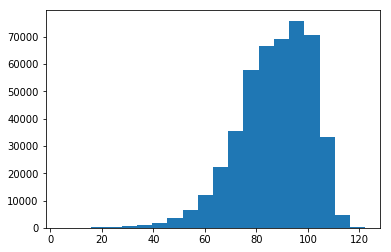

In [10]:
# Launch Speed (Exit Velocity) Distribution

plt.hist(df_clean['launch_speed'], bins=20)
plt.show()

In [11]:
# correlations

df3.corr()['launch_speed'].sort_values()

hc_y                -0.504623
zone                -0.219529
vy0                 -0.098322
pitch_type_CH       -0.069364
vz0                 -0.067024
pitch_type_SL       -0.056849
pitch_type_CU       -0.034893
ax                  -0.034683
pfx_x               -0.033900
pitch_type_FC       -0.025088
pitch_type_FS       -0.019083
hc_x                -0.017476
release_pos_y       -0.011590
release_pos_x       -0.007508
pitch_type_EP       -0.006349
pitch_type_KC       -0.004275
pitch_type_KN       -0.002794
pitch_type_FO       -0.001725
pitch_type_CS       -0.001503
pitch_type_SC       -0.000428
plate_x             -0.000115
batter               0.004211
release_spin_rate    0.006371
release_extension    0.011617
pitcher              0.012715
release_pos_z        0.015307
vx0                  0.019891
pitch_type_FT        0.020415
pitch_type_SI        0.027020
sz_top               0.029390
plate_z              0.041089
sz_bot               0.046397
pfx_z                0.071800
ay        

<br>
<br>

**Split Data For Train/Test (2017-2019) and Out Of Sample (2020)**

In [12]:
df_2020 = df3[(df3['game_date'] > '2020-01-01') & (df3['game_date'] < '2020-12-31')]
df_2020.shape

(46072, 43)

In [13]:
df_2017_2019 = df3[(df3['game_date'] > '2017-01-01') & (df3['game_date'] < '2019-12-31')]
df_2017_2019.shape

(369879, 43)

<br>
<br>
<br>
<br>

## Train the model using XGB Regressor With Hyper-parameters from tuning process

In [14]:
# Load Batter and Pitcher Names (additional pull from pybaseball)

batters = pd.read_csv('batter_names.csv')
batters = batters[['batter', 'batter_name_first', 'batter_name_last']]

pitchers = pd.read_csv('pitcher_names.csv')
pitchers = pitchers[['pitcher', 'pitchers_name_first', 'pitchers_name_last']]

In [15]:
# Prep 2017 - 2020 data for modeling

y = df_2017_2019['launch_speed']

x = df_2017_2019.drop(['launch_speed', 'batter', 'pitcher', 'game_date', 'events', 'description', 'zone','hc_y', 'hc_x',], 1)

# For feature importance graphic
x_col = df_2017_2019.drop(['launch_speed', 'batter', 'pitcher', 'game_date', 'events', 'description', 'zone','hc_y', 'hc_x',], 1)

player_ids = df_2017_2019[['batter','pitcher']]

print(y.shape)
print(x.shape)

(369879,)
(369879, 34)


In [16]:
# Train/Test Split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state = 21)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(258915, 34)
(110964, 34)
(258915,)
(110964,)


<br>
<br>

In [17]:
# Generate model


start = time.time()

#model = xgb.XGBRegressor(seed=21)
model = xgb.XGBRegressor(seed=21, gamma = 2, learning_rate = 0.5, max_depth = 5, min_child_weight = 0.05, 
                         n_estimators = 40, subsample = 0.9)

model.fit(x_train, y_train)

print('Runtime: ', time.time() - start)

C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Runtime:  19.160385608673096


In [18]:
# Evaluate

y_pred = model.predict(x_test)

# R^2
print('R^2 = ', r2_score(y_test, y_pred))
# MAE
print('MAE = ', mean_absolute_error(y_test, y_pred))
# RMSE
print('RMSE = ', np.sqrt(mean_absolute_error(y_test, y_pred)))

R^2 =  0.3607655017857324
MAE =  8.269520318219806
RMSE =  2.8756773668511224


**As you can see, RMSE is 2.87 mph. Which is great!**

<br>
<br>
<br>

## Run 2020 data through the trained model 

In [19]:
info_2020 = df_2020

x_2020 = df_2020.drop(['launch_speed', 'batter', 'pitcher', 'game_date', 'events', 'description', 'zone', 'hc_y', 'hc_x'], 1)

y_pred_2020 = model.predict(x_2020)

info_2020['predicted_launch_speed'] = y_pred_2020.tolist()

info_2020['launch_speed_difference'] = info_2020['launch_speed'] - info_2020['predicted_launch_speed']

info_2020 = info_2020.merge(batters, on='batter', how ='left')
info_2020 = info_2020.merge(pitchers, on='pitcher', how='left')

C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
# Generate predictions on 2020 data

y_pred_2020 = model.predict(x_2020)

In [21]:
# Create EVOE metric by subtracting predicted exit velocity from actual

info_2020['predicted_launch_speed'] = y_pred_2020.tolist()

info_2020['launch_speed_difference'] = info_2020['launch_speed'] - info_2020['predicted_launch_speed']

info_2020 = info_2020.merge(batters, on='batter', how ='left')
info_2020 = info_2020.merge(pitchers, on='pitcher', how='left')

In [22]:
# Evaluate Batter Performance

batter_aggregated_2020 = info_2020.groupby('batter').agg({'launch_speed_difference': ['mean', 'min', 'max', 'count']})
batter_aggregated_2020 = batter_aggregated_2020.merge(batters, on='batter', how ='left')

batter_aggregated_2020_filtered = batter_aggregated_2020[batter_aggregated_2020[('launch_speed_difference', 'count')] > 50]
batter_aggregated_2020_filtered.sort_values(by=[('launch_speed_difference', 'mean')], inplace=True, ascending=False)
batter_aggregated_2020_filtered.head(30)

C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,batter,"(launch_speed_difference, mean)","(launch_speed_difference, min)","(launch_speed_difference, max)","(launch_speed_difference, count)",batter_name_first,batter_name_last
442,646240.0,7.282544,-23.950180,36.084782,162,rafael,devers
527,665487.0,6.563766,-30.757184,42.681433,177,fernando,tatis
84,518626.0,6.359232,-13.339389,18.339842,57,josh,donaldson
229,593934.0,5.703671,-29.835313,25.015309,101,miguel,sano
531,665742.0,5.459882,-21.962625,25.292599,126,juan,soto
497,663647.0,5.134507,-25.236559,27.767283,64,ke'bryan,hayes
48,467055.0,5.117631,-55.011517,27.581595,66,pablo,sandoval
548,668227.0,4.888464,-37.280991,26.703423,100,randy,arozarena
149,547989.0,4.819108,-44.826025,41.595234,195,josé,abreu
215,592626.0,4.720819,-50.163045,25.192192,113,joc,pederson


In [23]:
# Used to place results in CSV

#batter_aggregated_2020.to_csv('2020_all_batters.csv')
#batter_aggregated_2020_filtered.to_csv('2020_all_batters_filtered.csv')

<br>
<br>
<br>
<br>
<br>

## k-Means Clustering

In [24]:
# LOAD DATA
df = pd.read_csv('2020_all_batters_filtered.csv')
df.head()

,batter,EVOE AVG,EVOE MIN,EVOE MAX,COUNT,batter_name_first,batter_name_last
0,646240,7.282544,-23.950180,36.084782,162,rafael,devers
1,665487,6.563766,-30.757184,42.681433,177,fernando,tatis
2,518626,6.359232,-13.339389,18.339842,57,josh,donaldson
3,593934,5.703671,-29.835313,25.015309,101,miguel,sano
4,665742,5.459882,-21.962625,25.292599,126,juan,soto


In [25]:
# Filter for EVOE and Count
df_filtered = df[['EVOE AVG', 'COUNT']]

names = df[['batter', 'batter_name_first', 'batter_name_last']]

In [26]:
# NORMALIZE EVOE AND COUNT
min_max_scaler = MinMaxScaler().fit(df_filtered)

dfNorm= min_max_scaler.transform(df_filtered)

C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


<br>
<br>

**Determine optimal number of clusters**

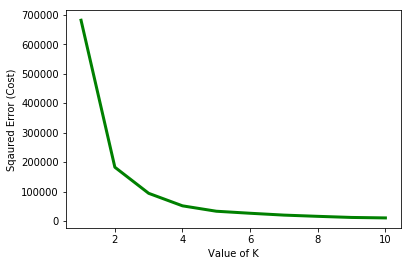

In [27]:
#Function
def cluster_sizes(clusters):
    #clusters is an array of cluster labels for each instance in the data
    
    size = {}
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]

    for c in cluster_labels:
        size[c] = len(df[clusters == c])
    return size



cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(df_filtered) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

<br>

In [28]:
# Want to use 4 to capture additional nuances

kmeans = KMeans(n_clusters=4, max_iter=500)
kmeans.fit(dfNorm)
clusters = kmeans.predict(dfNorm)

size = cluster_sizes(clusters)

for c in size.keys():
    print("Size of Cluster", c, "= ", size[c])

Size of Cluster 0 =  72
Size of Cluster 1 =  82
Size of Cluster 2 =  95
Size of Cluster 3 =  109


Text(0, 0.5, 'Batted Ball Events Count')

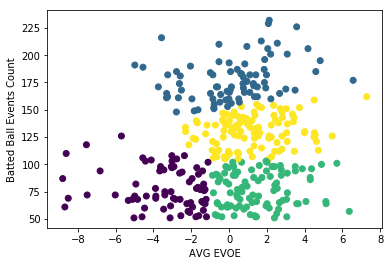

In [29]:
# Visualize Clusters

plt.scatter(df_filtered['EVOE AVG'], df_filtered['COUNT'], c=clusters)
plt.xlabel("AVG EVOE") 
plt.ylabel("Batted Ball Events Count")

In [30]:
# Put results in DF and Evaluate


results = df_filtered
results.shape


results['cluster'] = clusters
results['batter_id'] = names['batter']
results['Last Name'] = names['batter_name_last']
results['First_Name'] = names['batter_name_first']




cluster0 = results[results['cluster'] == 0]
cluster1 = results[results['cluster'] == 1]
cluster2 = results[results['cluster'] == 2]
cluster3 = results[results['cluster'] == 3]

c_mean0 = cluster0['EVOE AVG'].mean()
c_mean1 = cluster1['EVOE AVG'].mean()
c_mean2 = cluster2['EVOE AVG'].mean()
c_mean3 = cluster3['EVOE AVG'].mean()

count_mean0 = cluster0['COUNT'].mean()
count_mean1 = cluster1['COUNT'].mean()
count_mean2 = cluster2['COUNT'].mean()
count_mean3 = cluster3['COUNT'].mean()

print('Cluster 0 mean EVOE: ', c_mean0)
print('Cluster 1 mean EVOE: ', c_mean1)
print('Cluster 2 mean EVOE: ', c_mean2)
print('Cluster 3 mean EVOE: ', c_mean3)
print()
print('Cluster 0 mean Count: ', count_mean0)
print('Cluster 1 mean Count: ', count_mean1)
print('Cluster 2 mean Count: ', count_mean2)
print('Cluster 3 mean Count: ', count_mean3)

Cluster 0 mean EVOE:  -3.4321614703749996
Cluster 1 mean EVOE:  0.2036638192195116
Cluster 2 mean EVOE:  1.537574438147368
Cluster 3 mean EVOE:  1.2365129330917426

Cluster 0 mean Count:  78.77777777777777
Cluster 1 mean Count:  177.53658536585365
Cluster 2 mean Count:  76.9578947368421
Cluster 3 mean Count:  130.3302752293578


C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [31]:
# Evaluate Cluster 0 for Performers > Cluster AVG EVOE

value = cluster0[cluster0['EVOE AVG'] >= c_mean0]

value['AVG EVOE Difference'] = (abs(value['EVOE AVG'] - c_mean0))

value_results = value.sort_values('AVG EVOE Difference', ascending=False)
value_results.head(40)

C:\Users\Sean Sullivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,EVOE AVG,COUNT,cluster,batter_id,Last Name,First_Name,AVG EVOE Difference
259,-1.114352,102,0,592743,simmons,andrelton,2.317809
261,-1.195249,52,0,543309,higashioka,kyle,2.236913
262,-1.215357,68,0,457727,maybin,cameron,2.216805
264,-1.268324,64,0,647351,toro,abraham,2.163838
265,-1.270333,77,0,543401,kipnis,jason,2.161829
266,-1.322526,76,0,592325,gamel,ben,2.109635
267,-1.344856,82,0,666185,carlson,dylan,2.087306
268,-1.360388,58,0,649557,díaz,aledmys,2.071773
269,-1.362866,65,0,572191,taylor,michael,2.069295
270,-1.403785,94,0,459964,joyce,matthew,2.028377
